## Imports

In [1]:
import os
import sys
import pathlib

import cv2
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

import torchvision
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt 
import albumentations as albu

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>"))

# Fix to be able to import python modules inside a notebook
os.chdir('..')

# Useful extensions
# %load_ext watermark
# %watermark -v -n -m -p numpy,torch,albumentations,photosynthesis_metrics

# %load_ext autoreload
# %autoreload 2

# Nice plot formating
%matplotlib inline

In [3]:
!ls

configs  Makefile    preprocess.py  requirements.txt  train.py
data	 notebooks   __pycache__    src
logs	 predict.py  README.md	    tmp.txt


# Store embeddings as .npy

In [189]:
df = pd.read_csv("logs/genet_normal_384_hard_arcface80_15/train_val.csv")
df.head()

,file_path,label,full_path,hash_md5,original_size,aspect_ratio,is_train,is_query,embeddings
0,DIGIX_000000/19BRS2LZXV4M865W.jpg,0,data/raw/train_data/DIGIX_000000/19BRS2LZXV4M8...,b2a51756bcc2747e9c2b1705e2698c48,"(1080, 1440)",0.7500,False,True,"[0.05527299642562866, -0.02226325124502182, 0...."
1,DIGIX_000000/7WMZS8Q2V06E54FL.jpg,0,data/raw/train_data/DIGIX_000000/7WMZS8Q2V06E5...,06c03ce2c568bc0d27db07c8e5535f8d,"(1368, 1824)",0.7500,False,False,"[0.014345978386700153, -0.002005089307203889, ..."
2,DIGIX_000000/9WS85AHRBXKGOQED.jpg,0,data/raw/train_data/DIGIX_000000/9WS85AHRBXKGO...,b8df6b3a7ede7d9e71ac8433236e4a56,"(1080, 1440)",0.7500,False,False,"[0.037044163793325424, -0.04289752244949341, 0..."
3,DIGIX_000000/BWYUXPDGAJFQ05ZV.jpg,0,data/raw/train_data/DIGIX_000000/BWYUXPDGAJFQ0...,163b7f61d176093a804b1836a9a445d3,"(1078, 1440)",0.7486,False,False,"[0.0006333903293125331, 0.022377224639058113, ..."
4,DIGIX_000000/D02Y6MGNLV3JABXW.jpg,0,data/raw/train_data/DIGIX_000000/D02Y6MGNLV3JA...,9ef30057a09c240e8908b124586ad29f,"(2736, 3648)",0.7500,False,False,"[0.047589678317308426, 0.04539687931537628, 0...."


In [190]:
val_embeddings = torch.tensor(list(map(eval, df["embeddings"].values)))

In [194]:
data = {
    "embeddings": val_embeddings,
    "index": np.arange(len(val_embeddings))
}
np.save("logs/genet_normal_384_hard_arcface80_15/val_embeddings.npy", data)

In [198]:
data = np.load("logs/genet_normal_384_hard_arcface80_15/val_embeddings.npy", allow_pickle=True)

In [208]:
data.item()

{'embeddings': array([[ 0.055273  , -0.02226325,  0.03325599, ...,  0.02732552,
         -0.02888568,  0.01831377],
        [ 0.01434598, -0.00200509,  0.06059453, ...,  0.091722  ,
         -0.04650832, -0.02771214],
        [ 0.03704416, -0.04289752,  0.08048323, ...,  0.06726942,
         -0.03850769, -0.03267699],
        ...,
        [-0.025825  ,  0.05240931, -0.04923972, ..., -0.05179172,
          0.00763657, -0.00634171],
        [-0.02853927,  0.03427675, -0.06339592, ..., -0.04818422,
         -0.00210724, -0.03128156],
        [-0.01696584,  0.02949731, -0.01899906, ..., -0.07126053,
          0.00232139, -0.01396275]], dtype=float32),
 'indexes': [0,
  3,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  16,
  17,
  18,
  19,
  20,
  22,
  27,
  28,
  33,
  36,
  38,
  43,
  44,
  47,
  49,
  50,
  52,
  53,
  60,
  61,
  68,
  70,
  75,
  76,
  79,
  82,
  85,
  87,
  88,
  91,
  98,
  102,
  103,
  104,
  107,
  110,
  119,
  129,
  133,
  137,
  138,
  140,
  141

In [184]:
from ipywidgets import interact, interactive, fixed, interact_manual
def show_predictions(query_idx, config_path, dba=False, aqe=False, diffusion=False, size=384):
    """Plots predictions from submission.csv"""
    filename =  f"submission{'_dba' if dba else ''}{'_aqe' if aqe else ''}_{size}.csv"
    df = pd.read_csv(
        pathlib.Path(config_path) / filename, header=None)
    df[1] = df[1].apply(lambda x: x[1:])
    df[10] = df[10].apply(lambda x: x[:-1])
    # Sort, so that results indexes are always same
    df.sort_values(by=0, inplace=True)
    query_file = os.path.join("data/interim/test_data_A_384/query", df.iloc[query_idx].values[0])
    gallery_files = [os.path.join("data/interim/test_data_A_384/gallery", path) for path in df.iloc[query_idx].values[1:]]
#     print(query_file, "\n", gallery_files)
    query = cv2.imread(query_file)
    query = cv2.cvtColor(query, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(20,15))
    plt.subplot(1, 11, 1)
    plt.imshow(query)
    for i in range(10):
        image = cv2.imread(gallery_files[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.subplot(1, 11, i + 1)
        plt.imshow(image)

In [ ]:
CONFIG_PATH = pathlib.Path("logs/genet_small_384_light_arcface80_1/") 
SIZE = 384

interact_manual(show_predictions, config_path=fixed(CONFIG_PATH), query_idx=(0,9599),)

In [183]:
test_df = pd.read_csv("logs/genet_normal_384_hard_arcface80_15/submission_dba_aqe_None.csv", header=None)
# len(test_df)
print(len(test_df[0].unique()))

test_df.head()

58666


,0,1,2,3,4,5,6,7,8,9,10
0,0167QIBDLWNZCG3A.jpg,{B2Q6TNU3AMXZWKI8.jpg,I69S3EJ5MXZWQN7T.jpg,8G9PHDZ0O2BUYI7F.jpg,0Y8Z9FIKGO5U3T4B.jpg,ZHBI19SKYFMVJW6N.jpg,YOKBGC0S8HATZJQ6.jpg,T7NCBD0MWQPKIZ5U.jpg,SHMKOEN7TV4G0F5Q.jpg,PQEYBVK9RH41A837.jpg,GF63ZY0OUKIB4VLX.jpg}
1,026FVTYGZO9QS7WP.jpg,{IDY5T0V23MJ1L4EU.jpg,U2DXSWV6F4I1RBON.jpg,VYNZEQGLKOJPTU98.jpg,ZBU89GYN5QH3SXA1.jpg,VT9Y0X2IUC8BAGZ5.jpg,U7MNFPJ08O1KICDS.jpg,VX7NKEFPQYJ3AW1D.jpg,SPNABG8HX5934WIK.jpg,N2V5SH0QMUEZG13D.jpg,LE25NC931U76XV8Q.jpg}
2,02JQF4KT5I3WUAV1.jpg,{J0K7TS3M6NEYP1VL.jpg,XBCM09JY46F2183L.jpg,B8N2XJIKPLDFQOW4.jpg,4A9THO7W8NRKQLBU.jpg,QGIC3AS07Y9MHLD4.jpg,CBYX2OVEANSKLZGD.jpg,8ISE04NXQT2GK69J.jpg,VW0NP865SMILUG3A.jpg,NGR24XT1QUSCJ05B.jpg,YIFCJ56L9H8MKZT2.jpg}
3,02NK1I9GDPV53E7W.jpg,{1IORCZASMYQWET6F.jpg,96ZHFYK02AW4ORJX.jpg,60NR5FPHZ3K2IOJW.jpg,1GIF0YEKZHPSTBDL.jpg,U0PF7TNRQEZ3VI1W.jpg,Z09IGR4X2MVKQC6L.jpg,DHN4ZCVA02UWKBLG.jpg,8OWI3AJVKZL7SQB1.jpg,1MK78TDFGX96YH4Q.jpg,L9YI6UZPO5NBQ12R.jpg}
4,02SJWKZYADBEP537.jpg,{U50E7Q319CHDO2KG.jpg,D3BQ65R2M7ACNFZP.jpg,PB8QAT5C07JZ63RW.jpg,HLQXVI9GPD2KC3AE.jpg,I0O537Z6RW24QNGB.jpg,5CYNFROBI0M297QX.jpg,45PUVATNWFSGBZQR.jpg,7152YNW49TVLSZGO.jpg,YO63IHBUNV9G7JK5.jpg,JCYFB84NH2SAI0XK.jpg}


In [4]:
from loguru import logger
import albumentations.pytorch as albu_pt
class Dataset(torch.utils.data.Dataset):
    _aspect_ratios = np.array([2, 16 / 9, 3 / 2, 4 / 3, 5 / 4, 1, 4 / 5, 3 / 4, 2 / 3, 9 / 16, 1 / 2])

    def __init__(self, root="data/interim", transform=None, train=None, size=512):
        df = pd.read_csv(os.path.join(root, "train_val.csv"))
        
        if train is not None:
            df = df[df["is_train"].astype(np.bool) == train]
    
        self.filenames = [
            os.path.join(root, f"train_data_{size}", path) for path in df["file_path"].values.tolist()]

        # Сheck that all images exist
        assert map(lambda x: pathlib.Path(x).exists(), self.filenames), "Found missing images!"

        self.targets = df["label"].values.tolist()
        self.ar = df["aspect_ratio"].values

        # For each aspect ration in `ar` find closest value from the
        # `_aspect_ratios` and return it's index (group)
        self.group_ids = np.argmin(
            np.abs(self._aspect_ratios.reshape(1, -1) - self.ar.reshape(-1, 1)),
            axis=1
        )

        self.sizes = []
        for group in self.group_ids:
            ar = self._aspect_ratios[group]
            # Resize image to have `size` shape on smaller side and be devidable by 16 on another
            if ar <= 1:
                H = size
                W = int(size / ar) // 8 * 8
            else:
                W = size
                H = int(size * ar) // 8 * 8
            self.sizes.append((H, W))

        logger.info(f"Using sizes {set(self.sizes)} for {'train'if train else 'validation'}")
        self.transform = albu.Compose([albu_pt.ToTensorV2()]) if transform is None else transform

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        # logger.info(f"Index {index}")
        image = cv2.imread(self.filenames[index], cv2.IMREAD_COLOR)
        # logger.info(f"{index} Size before reshape {image.shape}")
        image = cv2.resize(image, self.sizes[index])
        # logger.info(f"{index} Size after reshape {image.shape}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transform(image=image)["image"]

        target = self.targets[index]

        return image, target

    def __len__(self):
        return len(self.filenames)

In [5]:
from src.augmentations import get_aug
from src.utils import ToCudaLoader
from src.datasets import GroupedBatchSampler

aug = get_aug('val', size=512)
BATCH_SIZE = 32

dataset = Dataset(root="data/interim", transform=aug, train=None, size=512)

gb_sampler = GroupedBatchSampler(
    sampler=torch.utils.data.sampler.SequentialSampler(dataset),
    group_ids=dataset.group_ids,
    batch_size=BATCH_SIZE,
    drop_uneven=False,
)

loader = torch.utils.data.DataLoader(
    dataset,
    num_workers=8,
    pin_memory=False,
    batch_sampler=gb_sampler,
)

loader = ToCudaLoader(loader)
logger.info(f"Len dataset {len(dataset)}")

# GB sampler changes the order of images depending on batch size
indexes = [idx for batch in list(gb_sampler) for idx in batch]


2020-09-24 11:05:54.154 | INFO     | __main__:__init__:40 - Using sizes {(768, 512), (512, 512), (640, 512), (512, 1024), (512, 768), (1024, 512), (512, 640), (680, 512), (904, 512), (512, 904), (512, 680)} for validation
2020-09-24 11:05:54.165 | INFO     | __main__:<module>:25 - Len dataset 68601


In [6]:
from predict import predict_from_loader
from src.models import Model
import pathlib

# Get model
model = Model(
    arch="genet_normal",
    model_params={},
    embedding_size=512,
    pooling="gem").cuda()
# logger.info(model)

# Init
checkpoint = torch.load(pathlib.Path("logs/genet_normal_384_hard_arcface80_15") / f"model.chpn")
model.load_state_dict(checkpoint["state_dict"], strict=False)

<All keys matched successfully>

In [7]:
embeddings = predict_from_loader(model, loader)
# embeddings = torch.tensor(embeddings)

100%|██████████| 2150/2150 [06:18<00:00,  5.68it/s]


In [44]:
df = pd.read_csv("data/interim/train_val.csv")
print(f"Length: {len(df)}, num classes: {len(df.label.unique())}")

# With BS=1 df should be same 
df = df.iloc[indexes]

# Hack to save torch.Tensor into pd.DataFrame
df["embeddings"] = list(map(lambda r: np.array(r).tolist(), embeddings))
df.head(3)

Length: 68601, num classes: 2837


,file_path,label,full_path,hash_md5,original_size,aspect_ratio,is_train,is_query,embeddings
0,DIGIX_000000/19BRS2LZXV4M865W.jpg,0,data/raw/train_data/DIGIX_000000/19BRS2LZXV4M8...,b2a51756bcc2747e9c2b1705e2698c48,"(1080, 1440)",0.75,False,True,"[0.05527299642562866, -0.02226325124502182, 0...."
3,DIGIX_000000/7WMZS8Q2V06E54FL.jpg,0,data/raw/train_data/DIGIX_000000/7WMZS8Q2V06E5...,06c03ce2c568bc0d27db07c8e5535f8d,"(1368, 1824)",0.75,False,False,"[0.014345978386700153, -0.002005089307203889, ..."
5,DIGIX_000000/9WS85AHRBXKGOQED.jpg,0,data/raw/train_data/DIGIX_000000/9WS85AHRBXKGO...,b8df6b3a7ede7d9e71ac8433236e4a56,"(1080, 1440)",0.75,False,False,"[0.037044163793325424, -0.04289752244949341, 0..."


# Change cdist to faiss library

In [43]:
import math
batch = torch.randn(16, 3, 64, 64)

# torch.nn.functional.interpolate(batch, scale_factor=1 / math.sqrt(2))
torch.nn.functional.interpolate(batch, scale_factor=math.sqrt(2))


torch.Size([16, 3, 90, 90])

In [55]:
# Test kNN and compare results with cdist search
config_path = pathlib.Path("logs/genet_normal_384_hard_arcface80_15")

# Read DF
df_val = pd.read_csv(config_path / "train_val.csv")
val_embeddings = np.array(list(map(eval, df_val["embeddings"].values)))
query_mask = df_val["is_query"].values.astype(np.bool)
val_labels = df_val["label"].values

# Shape (n_embeddings, embedding_dim)
query_embeddings, gallery_embeddings = val_embeddings[query_mask], val_embeddings[~query_mask]
query_labels, gallery_labels = val_labels[query_mask], val_labels[~query_mask]
logger.info(f"Validation query size - {len(query_embeddings)}, gallery size - {len(gallery_embeddings)}")
del val_embeddings

2020-09-24 14:59:14.142 | INFO     | __main__:<module>:13 - Validation query size - 1702, gallery size - 21969


In [66]:
conformity_matrix = torch.tensor(query_labels.reshape(-1, 1) == gallery_labels)

In [67]:
conformity_matrix.shape, ids.shape

(torch.Size([1702, 21969]), (1702, 1000))

In [73]:

class kNN(object):
    """k Nearest Neighbors class.
    Inits database and performes search in it.
    Uses Numpy arrays, not PyTorch tensors

    Args:
        embeddings: Matrix of gallery embeddings. Shape (n_emb x emb_dim)
        distance: Distance metric, one of {'cosine', 'euclidean'}
    """

    def __init__(self, embeddings: torch.Tensor, distance: str = 'cosine', use_gpu=False):
        embeddings = np.array(embeddings)
        if embeddings.dtype != np.float32:
            embeddings = embeddings.astype(np.float32)
        self.N, self.embedding_size = embeddings.shape

        # Store embeddings, so that they can be easyly found by index
        self.embeddings = embeddings if embeddings.flags['C_CONTIGUOUS'] \
                               else np.ascontiguousarray(embeddings)

        self.index = {
            'cosine': faiss.IndexFlatIP,
            'euclidean': faiss.IndexFlatL2
        }[distance](self.embedding_size)
        if use_gpu:
            self.index = faiss.index_cpu_to_all_gpus(self.index)
            
        # Add data to index in batches
        for i in range(0, self.N, 10000):
            self.index.add(self.embeddings[i: i + 10000])
            

    def search(self, queries, topk):
        """Search in database
        Args:
            queries: Matrix of query embeddings. Shape (n_que x emb_dim)
            topk: get top-k results
        Returns:
            distances: similarities of k-NN. Shape (n_que x topk)
            ids: indexes of k-NN from gallery. Shape (n_que x topk)
        """
        queries = np.asarray(queries)
        queries = queries.astype(np.float32)
        queries = np.ascontiguousarray(queries)
        distances, ids = self.index.search(queries, topk)
        return torch.tensor(distances), torch.tensor(ids)


In [163]:

def query_expansion(query_embeddings, gallery_embeddings, topk=10, alpha=3):
    """
    Implementation of Data Base Augmentation / Alpha Query Expansion
    Args:
        query_embeddings (Tensor): Shape (N, embedding_dim)
        gallery_embeddings (Tensor): Shape (M, embedding_dim)
        topk (int): How many neighbours to use
        alpha (int): Power for neighbours reweighting
        include_self (bool): Flag to include original embed in new one
    """

    # Init kNN and find neighbours
    knn = kNN(embeddings=gallery_embeddings, distance='cosine')

    # Get distance matrix of shape (query_length x 1000) and corresponding indexes in gallery
    distances, perm_matrix = knn.search(query_embeddings, topk=topk)

    # Get weight
    if alpha is None:
        weight = torch.div(topk - torch.arange(topk) - 1, float(topk))[None, :, None]  # 1 x TOPK x 1
    else:
        weight = (distances ** alpha)[..., None]  # N x TOPK -> N x TOPK x 1
#         print(weight)

    new_embeddings = gallery_embeddings[perm_matrix] * weight  # N x TOPK x EMBED_SIZE * N x TOPK x 1
    new_embeddings = new_embeddings.sum(dim=1) + query_embeddings

    # new_embedding = (new_embedding.mean(dim=1) + query_embeddings) / 2
    new_embeddings = torch.nn.functional.normalize(new_embeddings, p=2, dim=1)
    print(new_embeddings.shape)
    # new_embedding = torch.nn.functional.normalize(new_embedding, p=2, dim=1)
    return new_embeddings

In [175]:
query_embeddings = torch.rand(100, 2)
gallery_embeddings = torch.rand(1000, 2)

query_embeddings = torch.nn.functional.normalize(query_embeddings, p=2, dim=1)
gallery_embeddings = torch.nn.functional.normalize(gallery_embeddings, p=2, dim=1)

In [176]:
query_embeddings_aqe = query_expansion(query_embeddings, gallery_embeddings, topk=30, alpha=None)

torch.Size([100, 2])


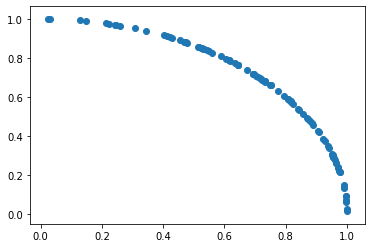

In [181]:
# plt.scatter(query_embeddings[:, 0], query_embeddings[:, 1])
plt.scatter(query_embeddings_aqe[:, 0], query_embeddings_aqe[:, 1])

In [124]:
# Matrix of pairwise cosin distances
distances = torch.cdist(query_embeddings, gallery_embeddings)
distances.max()
# alpha = 3
# Nearest neighbours
topk_vals, topk_ind = distances.neg().topk(5, dim=1)

(2 - topk_vals.neg()) * 0.5 , topk_vals, topk_ind

# gallery_embeddings = query_expansion(gallery_embeddings, gallery_embeddings, topk=10, alpha=5)
# cosine_dist = (2 - topk_vals.neg()) * 0.5  # cos = ((2 - l2_distances) / 2)
# weight = (cosine_dist ** alpha)[..., None]  # N x TOPK -> N x TOPK x 1
# # weight
# torch.sort(distances)
# if hparams.aqe:
#     query_embeddings = query_expansion(query_embeddings, gallery_embeddings, topk=3, alpha=5)

(tensor([[0.7432, 0.6742, 0.6738, 0.6679, 0.6641],
         [0.6637, 0.6288, 0.5736, 0.5688, 0.5482],
         [0.6790, 0.6172, 0.5959, 0.5894, 0.5379],
         [0.6209, 0.5911, 0.5868, 0.5548, 0.5431],
         [0.7893, 0.6328, 0.6081, 0.5798, 0.5584],
         [0.6405, 0.6310, 0.5883, 0.5671, 0.5205],
         [0.6711, 0.5892, 0.5820, 0.5594, 0.5541],
         [0.7468, 0.7366, 0.6559, 0.6219, 0.5898],
         [0.6304, 0.5630, 0.5508, 0.5505, 0.5456],
         [0.6336, 0.6057, 0.5596, 0.5301, 0.4905]]),
 tensor([[-0.5136, -0.6515, -0.6524, -0.6642, -0.6718],
         [-0.6725, -0.7425, -0.8528, -0.8624, -0.9036],
         [-0.6420, -0.7657, -0.8082, -0.8213, -0.9242],
         [-0.7583, -0.8177, -0.8265, -0.8904, -0.9138],
         [-0.4215, -0.7344, -0.7838, -0.8403, -0.8832],
         [-0.7191, -0.7381, -0.8234, -0.8657, -0.9591],
         [-0.6577, -0.8215, -0.8360, -0.8811, -0.8918],
         [-0.5064, -0.5269, -0.6883, -0.7561, -0.8204],
         [-0.7392, -0.8741, -0.8984, -0.

In [68]:
# Compare result of kNN
knn = kNN(embeddings=gallery_embeddings, distance='euclidean')

# Get distance matrix of shape (query_length x 1000)
distances, ids = knn.search(query_embeddings, topk=1000)
# distances = torch.tensor(distances)

# Take 1000 matches
# conformity_matrix = torch.gather(conformity_matrix, 1, torch.tensor(ids))

100%|██████████| 3/3 [00:00<00:00, 55.40it/s]


In [62]:
def map_at_k_2(perm_matrix: torch.Tensor, conformity_matrix: torch.Tensor, topk: int = 10) -> float:
    """Compute mean Average Precision (mAP@k) from distance matrix and conformity matrix.
    If topk parameter is None, returns mAP@R, see [1] for details.

    Args:
        perm_matrix: Shape (len_query x 1000)
        conformity_matrix: binary matrix with 1 on same label pos
            and 0 otherwise. Shape (len_query x len_gallery)
        topk: number of top examples for AP counting.

    Returns:
        mAP@k score

    Reference:
        [1] A Metric Learning Reality Check
            https://arxiv.org/pdf/2003.08505.pdf
    """
    conformity_matrix = conformity_matrix.type(torch.double)

    if topk is None:  # Compute mAP@R
        # Total total number of references that are the same class as the query.
        R = conformity_matrix.sum(dim=1)
        R_max = int(R.max())
    else:  # Compute mAP@k
        R = torch.ones(perm_matrix.size(0)) * topk
        R_max = topk

    R_mask = torch.cumsum(torch.ones((perm_matrix.size(0), R_max)), dim=1) <= R.reshape(-1, 1)

    # Sort matrix
    conformity_matrix = torch.gather(conformity_matrix, 1, perm_matrix)[:, :R_max] * R_mask
    precision = torch.cumsum(conformity_matrix, dim=-1) * conformity_matrix \
        / torch.arange(start=1, end=R_max + 1)
    average_precision = precision.sum(dim=-1) / conformity_matrix.sum(dim=-1)

    # If no match found at first k elements, AP is 0
    average_precision[average_precision.isnan()] = 0
    return average_precision.mean().item()

In [69]:

map10 = map_at_k_2(torch.tensor(ids), conformity_matrix, topk=10)
mapR = map_at_k_2(torch.tensor(ids), conformity_matrix, topk=None)

logger.info(
    f"Val: mAP@10 {map10:0.5f}, mAP@R {mapR:0.5f}")


2020-09-24 15:34:41.964 | INFO     | __main__:<module>:5 - Val: mAP@10 0.95582, mAP@R 0.94842


In [50]:
conformity_matrix.shape, distances.shape, ids.shape

(torch.Size([1702, 21969]), (1702, 1000), (1702, 1000))

In [ ]:
# Compare result of kNN and cdist
knn = kNN(embeddings=gallery_embeddings, distance='cosine')
distances, ids = knn.search(query_embeddings, topk=15522)
distances = torch.tensor(distances)

map10 = map_at_k_2(torch.tensor(ids), conformity_matrix, topk=10)
mapR = map_at_k_2(torch.tensor(ids), conformity_matrix, topk=None)

logger.info(
    f"Val: mAP@10 {map10:0.5f}, mAP@R {mapR:0.5f}")

In [19]:
# sampled_embeddings = []
# sampled_labels = []
# N = 5
# for label in df["label"].unique():
#     label_df = df[df.label == label]
#     label_embeddings = embeddings[label_df.index]
#     sampled_embeddings.extend(label_embeddings[:N])
#     sampled_labels.extend([label] * len(label_embeddings[:N]))
    

In [43]:
import math
batch = torch.randn(16, 3, 64, 64)

# torch.nn.functional.interpolate(batch, scale_factor=1 / math.sqrt(2))
torch.nn.functional.interpolate(batch, scale_factor=math.sqrt(2))


torch.Size([16, 3, 90, 90])

In [20]:
sampled_embeddings = np.array(sampled_embeddings)
sampled_embeddings.shape

(14133, 512)

In [21]:
# Compare result of kNN and cdist
knn = kNN(embeddings=sampled_embeddings, distance='euclidean')

# Get distance matrix of shape (n_emb x n_emb)
distances, ids = knn.search(sampled_embeddings, topk=len(sampled_embeddings))
# distances = torch.tensor(distances)


100%|██████████| 2/2 [00:00<00:00, 40.67it/s]


In [22]:
distances.shape, distances.max(), distances.min()

((14133, 14133), 2.727338, 0.0)

In [33]:
# %load_ext wurlitzer

In [23]:
from sklearn.manifold import TSNE
# from MulticoreTSNE import MulticoreTSNE as TSNE
tsne = TSNE(n_components=2,perplexity=30.0, n_iter=1000, metric='precomputed', init='random', method='barnes_hut', angle=0.5,)

In [24]:
sampled_embeddings_tsne = tsne.fit_transform(distances)

In [26]:
len(sampled_labels)

14133

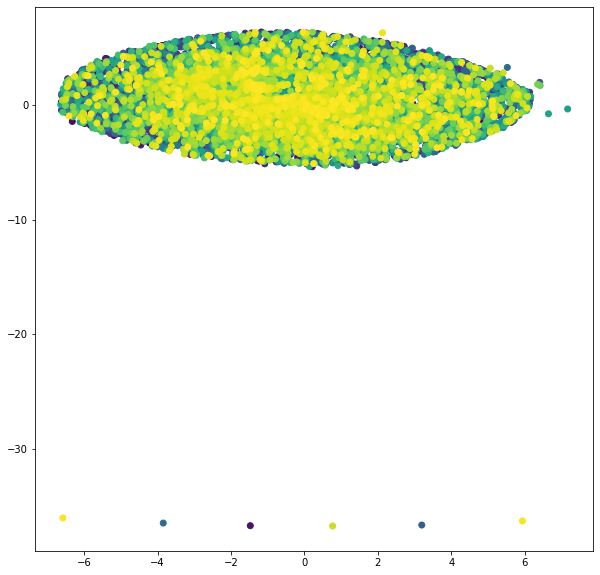

In [25]:
plt.figure(figsize=(10, 10))
plt.scatter(sampled_embeddings_tsne[:, 0], sampled_embeddings_tsne[:, 1], c=sampled_labels)

In [ ]:
# embeddings = np.array(embeddings)
# labels = df["label"].values

# DBSCAN clustering for each class

In [38]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

In [39]:
embeddings = torch.tensor(embeddings)

In [ ]:
def cluster_label(label, df):
    label_df = df[df.label == label]
    label_embeddings = embeddings[label_df.index]
    labels_true = [label] * len(label_df)
    
    distances = torch.cdist(label_embeddings, label_embeddings)

    # Compute tSNE
    tsne = TSNE(n_components=2,perplexity=30.0, n_iter=1000, metric='precomputed', init='random')
    label_embeddings_tsne = tsne.fit_transform(label_embeddings)
    
    # Compute DBSCAN
    db = DBSCAN(eps=0.5, metric='precomputed').fit(np.array(distances))
    cluster_labels = db.labels_

    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    n_noise_ = list(cluster_labels).count(-1)

    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, cluster_labels))
    print("Completeness: %0.3f" % metrics.completeness_score(labels_true, cluster_labels))
    print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, cluster_labels))
    print("Adjusted Rand Index: %0.3f"
          % metrics.adjusted_rand_score(labels_true, cluster_labels))
    print("Adjusted Mutual Information: %0.3f"
          % metrics.adjusted_mutual_info_score(labels_true, cluster_labels))

    # Black removed and is used for noise instead.
    unique_labels = set(cluster_labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (cluster_labels == k)

        xy = label_embeddings_tsne[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

        xy = label_embeddings_tsne[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()

# Not used